In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

In [4]:
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    
    # df['cons_cat'] = np.nan

#     # tes
#     df.loc[(df.sector_human=='tes')&\
#            (df.sector_mouse=='tes'), 'cons_cat'] = 'tes_cons'
#     df.loc[(df.sector_human=='tes')&\
#        (df.sector_mouse!='tes'), 'cons_cat'] = 'tes_not_cons'
    
#     # splicing
#     df.loc[(df.sector_human=='splicing')&\
#            (df.sector_mouse=='splicing'), 'cons_cat'] = 'Splicing_cons'
#     df.loc[(df.sector_human=='splicing')&\
#        (df.sector_mouse!='splicing'), 'cons_cat'] = 'tes_not_cons
    return df

def test_print_stat(df, test_col, test='mannwhitneyu'):
    # means of each dist and mann whitney u for each pair
    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Mean of human {s} {c} sector conserved genes: {temp[test_col].mean()}")


    for s in df.sector_human.unique().tolist():
        print()
        for c in df.sector_conserved.unique().tolist():
            temp = df.loc[(df.sector_human==s)&\
                          (df.sector_conserved==c)].copy(deep=True)
            print(f"Median of human {s} {c} sector conserved genes: {temp[test_col].median()}")

    print()
    for s in df.sector_human.unique().tolist():  
        temp = df.loc[df.sector_human==s].copy(deep=True)
        a = temp.loc[temp.sector_conserved==True][test_col].tolist()
        b = temp.loc[temp.sector_conserved==False][test_col].tolist()
        if test=='mannwhitneyu':
            stat, pval = st.mannwhitneyu(a,b,alternative='two-sided')   
            print(f'Mann whitney u human {s} cons vs not cons: {stat}, p={pval}')
        elif test=='ttest_ind':
            stat, pval = st.ttest_ind(a,b,alternative='two-sided')
            print(f'Ttest ind human {s} cons vs not cons: {stat}, p={pval}')

In [5]:
df_all = pd.DataFrame()

## Splicing

In [9]:
df = pd.read_csv('splice_flank_conservation.tsv', sep='\t')
df.head()

,gid,sector_mouse,sector_human,avg_score_per_bp_for_ics,sector_conserved
0,ENSG00000065135,simple,tes,0.135110,False
1,ENSG00000093009,mixed,splicing,0.095199,False
2,ENSG00000102098,mixed,mixed,0.180351,True
3,ENSG00000141562,mixed,mixed,0.080690,True
4,ENSG00000105971,simple,tes,0.045654,False


13494
Corr. between splice flank cons score and delta splicing ratio, pearson r=-0.025277581411155273 and pval=0.003699478395181807

Corr. between splice flank cons score and delta splicing ratio, spearman rho=-0.02275691093772317 and pval=0.00897054421765124


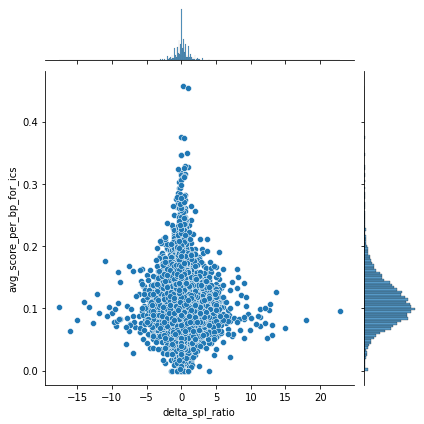

In [6]:
df = pd.read_csv('splice_flank_conservation.tsv', sep='\t')
df2 = read_cons_table()
df2['delta_spl_ratio'] = df2.splicing_ratio_human-df2.splicing_ratio_mouse
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', 'splicing_ratio_human',
           'splicing_ratio_mouse', 'delta_spl_ratio',
           'sector_human', 'sector_mouse', 'sector_conserved']]
df = df.merge(df2, how='left', on='gid')
df.head()

x = df.avg_score_per_bp_for_ics.tolist()
y = df.delta_spl_ratio.tolist()

r, pval = stats.pearsonr(x,y)
print(f'Corr. between splice flank cons score and delta splicing ratio, pearson r={r} and pval={pval}')

print()

rho, pval = stats.spearmanr(x,y)
print(f'Corr. between splice flank cons score and delta splicing ratio, spearman rho={rho} and pval={pval}')

sns.jointplot(df, x='delta_spl_ratio',
              y='avg_score_per_bp_for_ics')

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    # sns.boxplot(df, x=col, kind='kde',
    #             hue='sector_conserved',
    #             linewidth=1, common_norm=False)
    sns.boxplot(df, x='sector_conserved', y=col)
    plt.show()
    temp = df.loc[df.sector_human==feat]
    x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
    y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
    stat, pval = st.mannwhitneyu(x,y)
    print(f'{feat} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')

## TSS

Calculating tss TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 73812
# tsss >= 1 tpm: 64913
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of tsss reported: 50292
156184
50292
    Unnamed: 0               Name              gid  tss_len  tss_cons_score  \
17          17  ENSG00000000460_1  ENSG00000000460      140          1943.0   
18          18  ENSG00000000460_2  ENSG00000000460      101     169795359.0   
19          19  ENSG00000000460_3  ENSG00000000460      101     169794680.0   

    tss_bp_cons_score  
17       1.387857e+01  
18       1.681142e+06  
19       1.681135e+06  
13494
13494
Corr. between mean tss cons score and delta # tss, pearson r=0.08023560952890925 and pval=1.0132355229772212e-20
Corr. between mean tss cons score and delta # tss, spearman rho=0.20693732035657636 and pval=1.9675231311792126e-130

Corr. between max tss cons score and delta # tss, pearson r=0.14414674589056442 and pval=1.445620212344664e-63
Corr. between max tss cons sc

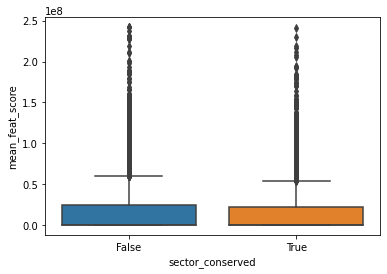

tss sector conserved vs. non conserved mean_feat_score stat: 224950.0, pval: 0.007931192312595217


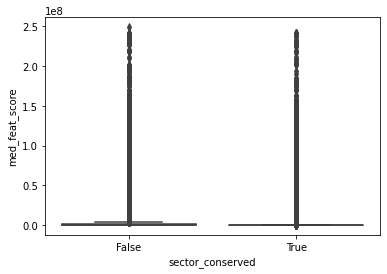

tss sector conserved vs. non conserved med_feat_score stat: 215194.5, pval: 0.0001121654141470729


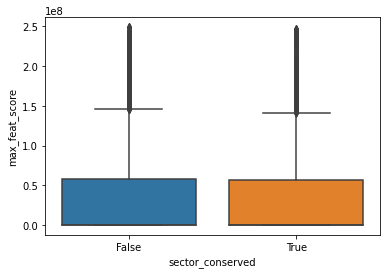

tss sector conserved vs. non conserved max_feat_score stat: 234298.0, pval: 0.13419312599343725


In [7]:
feat = 'tss'
df = pd.read_csv(f'human_{feat}_cons_score_2.tsv', sep='\t')

# get only the protein coding expressed tsss from mouse match samples
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, ids = get_tpm_table(h_ab,
               how=feat,
               min_tpm=1,
               gene_subset='protein_coding', 
               groupby=obs_col)
print(len(df.index))
df = df.loc[df.Name.isin(ids)]
print(len(df.index))
df = df.rename({'gene_id':'gid'}, axis=1)
print(df.loc[df.gid=='ENSG00000000460'])
df = df[[f'{feat}_cons_score', 'gid']]


# get sector conservation information
df2 = read_cons_table()
df2['delta_feat'] = df2[f'n_{feat}_human']-df2[f'n_{feat}_mouse']
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', f'n_{feat}_human',
          f'n_{feat}_mouse', 'delta_feat', 
          'sector_human', 'sector_mouse', 'sector_conserved']]

# compute mean score
temp = df.groupby('gid').mean().reset_index().rename({f'{feat}_cons_score':'mean_feat_score'}, axis=1)

# also compute max score
temp2 = df.groupby('gid').max().reset_index().rename({f'{feat}_cons_score':'max_feat_score'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# also compute median score
temp2 = df.groupby('gid').median().reset_index().rename({f'{feat}_cons_score':'med_feat_score'}, axis=1)
df = temp.merge(temp2, how='left', on='gid')

# merge with sector cons. information 
df = df.merge(df2, how='inner', on='gid')
print(len(df.index))

x = df['mean_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='mean_feat_score',
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['max_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='max_feat_score', 
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['med_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='med_feat_score', 
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    # sns.boxplot(df, x=col, kind='kde',
    #             hue='sector_conserved',
    #             linewidth=1, common_norm=False)
    sns.boxplot(df, x='sector_conserved', y=col)
    plt.show()
    temp = df.loc[df.sector_human==feat]
    x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
    y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
    stat, pval = st.mannwhitneyu(x,y)
    print(f'{feat} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')

## TES 

Calculating tes TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 87189
# tess >= 1 tpm: 76035
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of tess reported: 59903
187005
59903
    Unnamed: 0               Name              gid  tes_len  tes_cons_score  \
24          24  ENSG00000000460_1  ENSG00000000460      101     169854030.0   
25          25  ENSG00000000460_2  ENSG00000000460      140           247.0   
26          26  ENSG00000000460_3  ENSG00000000460      149           854.0   
29          29  ENSG00000000460_6  ENSG00000000460      101           933.0   

    tes_bp_cons_score  
24       1.681723e+06  
25       1.764286e+00  
26       5.731544e+00  
29       9.237624e+00  
13494
13494
Corr. between mean tes cons score and delta # tes, pearson r=0.09358045617939587 and pval=1.2371638684869465e-27
Corr. between mean tes cons score and delta # tes, spearman rho=0.19919609635184266 and pval=8.275391135067344e-121


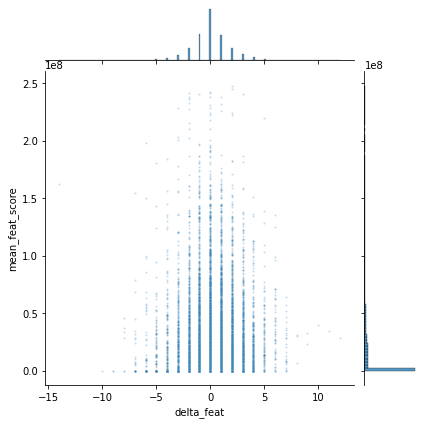


Corr. between max tes cons score and delta # tes, pearson r=0.13622633335542605 and pval=6.621500741963833e-57
Corr. between max tes cons score and delta # tes, spearman rho=0.21561317166747254 and pval=1.080592394951354e-141


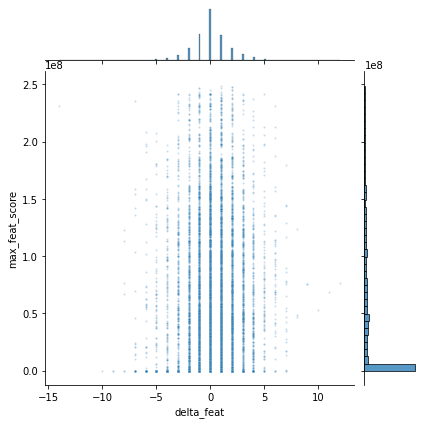


Corr. between med tes cons score and delta # tes, pearson r=0.07077316770945583 and pval=1.8591797761238642e-16
Corr. between med tes cons score and delta # tes, spearman rho=0.12209284955771525 and pval=5.578477061519327e-46


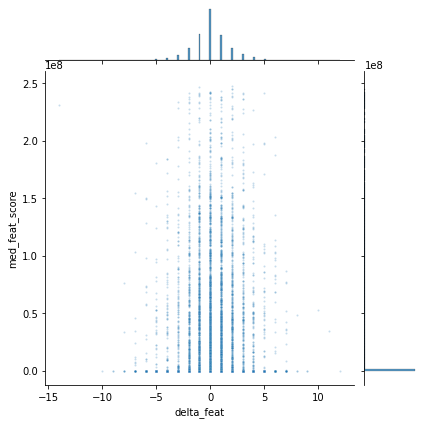

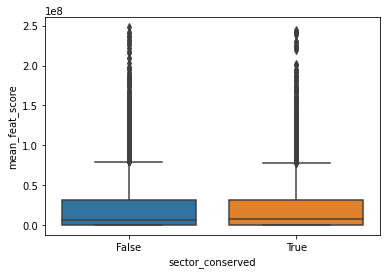

tes sector conserved vs. non conserved mean_feat_score stat: 1310591.0, pval: 0.0007166329360595637


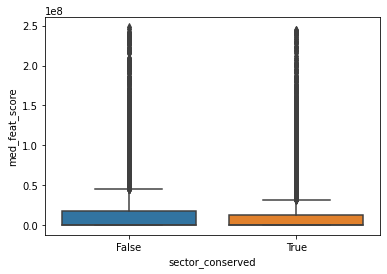

tes sector conserved vs. non conserved med_feat_score stat: 1210989.0, pval: 4.061707408564281e-12


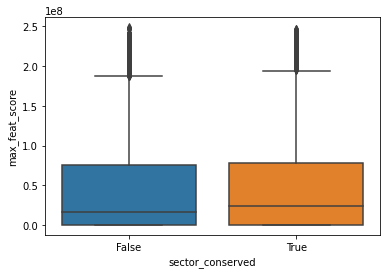

tes sector conserved vs. non conserved max_feat_score stat: 1397944.0, pval: 0.7886517022885906


In [28]:
feat = 'tes'
df = pd.read_csv(f'human_{feat}_cons_score_2.tsv', sep='\t')

# get only the protein coding expressed tess from mouse match samples
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, ids = get_tpm_table(h_ab,
               how=feat,
               min_tpm=1,
               gene_subset='protein_coding', 
               groupby=obs_col)
print(len(df.index))
df = df.loc[df.Name.isin(ids)]
print(len(df.index))
df = df.rename({'gene_id':'gid'}, axis=1)
print(df.loc[df.gid=='ENSG00000000460'])
df = df[[f'{feat}_cons_score', 'gid']]


# get sector conservation information
df2 = read_cons_table()
df2['delta_feat'] = df2[f'n_{feat}_human']-df2[f'n_{feat}_mouse']
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', f'n_{feat}_human',
          f'n_{feat}_mouse', 'delta_feat', 
          'sector_human', 'sector_mouse', 'sector_conserved']]

# compute mean score
temp = df.groupby('gid').mean().reset_index().rename({f'{feat}_cons_score':'mean_feat_score'}, axis=1)

# also compute max score
temp2 = df.groupby('gid').max().reset_index().rename({f'{feat}_cons_score':'max_feat_score'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# also compute median score
temp2 = df.groupby('gid').median().reset_index().rename({f'{feat}_cons_score':'med_feat_score'}, axis=1)
df = temp.merge(temp2, how='left', on='gid')

# merge with sector cons. information 
df = df.merge(df2, how='inner', on='gid')
print(len(df.index))

x = df['mean_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
sns.jointplot(df, x='delta_feat',
              y='mean_feat_score',
              joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['max_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
sns.jointplot(df, x='delta_feat',
              y='max_feat_score', 
              joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['med_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
sns.jointplot(df, x='delta_feat',
              y='med_feat_score', 
              joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    # sns.boxplot(df, x=col, kind='kde',
    #             hue='sector_conserved',
    #             linewidth=1, common_norm=False)
    sns.boxplot(df, x='sector_conserved', y=col)
    plt.show()
    temp = df.loc[df.sector_human==feat]
    x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
    y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
    stat, pval = st.mannwhitneyu(x,y)
    print(f'{feat} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')

,gid,mean_feat_score,max_feat_score,med_feat_score,n_tes_human,n_tes_mouse,delta_feat,sector_human,sector_mouse,sector_conserved
0,ENSG00000000003,1.677224e+07,100628620.0,9.975000e+02,4.0,2.0,2.0,tes,tes,True
1,ENSG00000000005,1.443000e+03,1443.0,1.443000e+03,1.0,1.0,0.0,simple,mixed,False
2,ENSG00000000457,4.246363e+07,169850962.0,1.382639e+03,3.0,3.0,0.0,mixed,mixed,True
3,ENSG00000000460,4.246402e+07,169854030.0,8.935000e+02,4.0,3.0,1.0,tes,tes,True
4,ENSG00000000938,1.380914e+07,27623334.0,1.380649e+07,1.0,1.0,0.0,mixed,simple,False
...,...,...,...,...,...,...,...,...,...,...
13489,ENSG00000284791,2.605419e+07,52107891.0,2.605419e+07,2.0,3.0,-1.0,tes,tes,True
13490,ENSG00000284797,1.824990e+07,18249900.0,1.824990e+07,1.0,1.0,0.0,simple,simple,True
13491,ENSG00000284862,1.806145e+08,180614538.0,1.806145e+08,1.0,6.0,-5.0,simple,tes,False
13492,ENSG00000284976,1.372193e+08,137219311.0,1.372193e+08,1.0,1.0,0.0,simple,tss,False


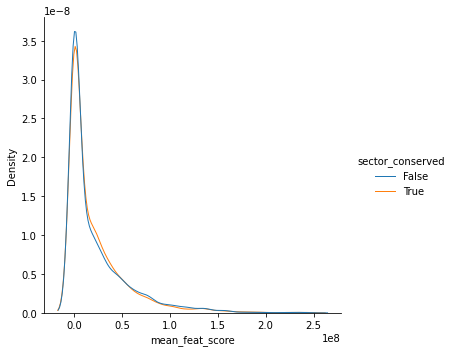

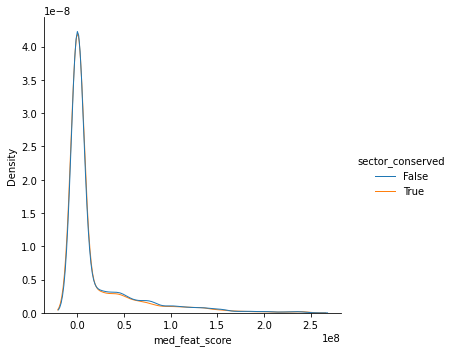

In [22]:
sns.displot(df, x='med_feat_score', kind='kde',
            hue='sector_conserved',
            linewidth=1, common_norm=False)